In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
import random
import math
from torch.utils.tensorboard import SummaryWriter
from collections import deque, namedtuple
import time
import gym


def weight_init(layers):
    for layer in layers:
        torch.nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')

In [ ]:
class QR_DQN(nn.Module):
    def __init__(self, state_size, action_size,layer_size, n_step, seed, N, layer_type="ff"):
        super(QR_DQN, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.input_shape = state_size
        self.action_size = action_size
        self.N = N

        self.head_1 = nn.Linear(self.input_shape[0], layer_size)
        self.ff_1 = nn.Linear(layer_size, layer_size)
        self.ff_2 = nn.Linear(layer_size, action_size*N)
        weight_init([self.head_1, self.ff_1])


    
    def forward(self, input):
        """
        
        """
        x = torch.relu(self.head_1(input))
        x = torch.relu(self.ff_1(x))
        out = self.ff_2(x)
        
        return out.view(input.shape[0], self.N, self.action_size)
    def get_action(self,input):
        x = self.forward(input)
        return x.mean(dim=1)


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size, device, seed, gamma, n_step=1):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.device = device
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        self.gamma = gamma
        self.n_step = n_step
        self.n_step_buffer = deque(maxlen=self.n_step)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        #print("before:", state,action,reward,next_state, done)
        self.n_step_buffer.append((state, action, reward, next_state, done))
        if len(self.n_step_buffer) == self.n_step:
            state, action, reward, next_state, done = self.calc_multistep_return()
            #print("after:",state,action,reward,next_state, done)
            e = self.experience(state, action, reward, next_state, done)
            self.memory.append(e)
    
    def calc_multistep_return(self):
        Return = 0
        for idx in range(self.n_step):
            Return += self.gamma**idx * self.n_step_buffer[idx][2]
        
        return self.n_step_buffer[0][0], self.n_step_buffer[0][1], Return, self.n_step_buffer[-1][3], self.n_step_buffer[-1][4]
        
    
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.stack([e.state for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(self.device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.stack([e.next_state for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)


class DQN_Agent():
    """Interacts with and learns from the environment."""

    def __init__(self,
                 state_size,
                 action_size,
                 Network,
                 layer_size,
                 n_step,
                 BATCH_SIZE,
                 BUFFER_SIZE,
                 LR,
                 TAU,
                 GAMMA,
                 UPDATE_EVERY,
                 device,
                 seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            Network (str): dqn network type
            layer_size (int): size of the hidden layer
            BATCH_SIZE (int): size of the training batch
            BUFFER_SIZE (int): size of the replay memory
            LR (float): learning rate
            TAU (float): tau for soft updating the network weights
            GAMMA (float): discount factor
            UPDATE_EVERY (int): update frequency
            device (str): device that is used for the compute
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.device = device
        self.TAU = TAU
        self.GAMMA = GAMMA
        self.UPDATE_EVERY = UPDATE_EVERY
        self.BATCH_SIZE = BATCH_SIZE
        self.Q_updates = 0
        self.n_step = n_step
        self.N = 32
        self.quantile_tau = torch.FloatTensor([i/self.N for i in range(1,self.N+1)]).to(device)

        self.action_step = 4
        self.last_action = None

        # Q-Network
        self.qnetwork_local = QR_DQN(state_size, action_size,layer_size, n_step, seed, self.N).to(device)
        self.qnetwork_target = QR_DQN(state_size, action_size,layer_size, n_step, seed, self.N).to(device)

        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)
        print(self.qnetwork_local)
        
        # Replay memory
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, self.device, seed, self.GAMMA, n_step)
        
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done, writer):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % self.UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.BATCH_SIZE:
                experiences = self.memory.sample()
                loss = self.learn(experiences)
                self.Q_updates += 1
                writer.add_scalar("Q_loss", loss, self.Q_updates)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy. Acting only every 4 frames!
        
        Params
        ======
            frame: to adjust epsilon
            state (array_like): current state
            
        """

        if self.action_step == 4:
            state = np.array(state)

            state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
            self.qnetwork_local.eval()
            with torch.no_grad():
                action_values = self.qnetwork_local.get_action(state)
            self.qnetwork_local.train()

            # Epsilon-greedy action selection
            if random.random() > eps: # select greedy action if random number is higher than epsilon or noisy network is used!
                action = np.argmax(action_values.cpu().data.numpy())
                self.last_action = action
                return action
            else:
                action = random.choice(np.arange(self.action_size))
                self.last_action = action 
                return action
            #self.action_step = 0
        else:
            self.action_step += 1
            return self.last_action

    def learn(self, experiences):
        """Update value parameters using given batch of experience tuples.
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        self.optimizer.zero_grad()
        states, actions, rewards, next_states, dones = experiences
        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().cpu() #.max(2)[0].unsqueeze(1) #(batch_size, 1, N)
        action_indx = torch.argmax(Q_targets_next.mean(dim=1), dim=1, keepdim=True)

        Q_targets_next = Q_targets_next.gather(2, action_indx.unsqueeze(-1).expand(self.BATCH_SIZE, self.N, 1)).transpose(1,2)

        assert Q_targets_next.shape == (self.BATCH_SIZE,1, self.N)
        # Compute Q targets for current states 
        Q_targets = rewards.unsqueeze(-1) + (self.GAMMA**self.n_step * Q_targets_next.to(self.device) * (1 - dones.unsqueeze(-1)))
        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(2, actions.unsqueeze(-1).expand(self.BATCH_SIZE, self.N, 1))
        # Compute loss
        td_error = Q_targets - Q_expected
        assert td_error.shape == (self.BATCH_SIZE, self.N, self.N), "wrong td error shape"
        huber_l = calculate_huber_loss(td_error, 1.0)
        quantil_l = abs(self.quantile_tau -(td_error.detach() < 0).float()) * huber_l / 1.0

        loss = quantil_l.sum(dim=1).mean(dim=1) # , keepdim=True if per weights get multipl
        loss = loss.mean()
        # Minimize the loss
        loss.backward()
        #clip_grad_norm_(self.qnetwork_local.parameters(),1)
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target)
        return loss.detach().cpu().numpy()            

    def soft_update(self, local_model, target_model):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.TAU*local_param.data + (1.0-self.TAU)*target_param.data)
            
def calculate_huber_loss(td_errors, k=1.0):
    """
    Calculate huber loss element-wisely depending on kappa k.
    """
    loss = torch.where(td_errors.abs() <= k, 0.5 * td_errors.pow(2), k * (td_errors.abs() - 0.5 * k))
    assert loss.shape == (td_errors.shape[0], 32, 32), "huber loss has wrong shape"
    return loss

def eval_runs(eps, frame):
    """
    Makes an evaluation run with the current epsilon
    """
    env = gym.make("CartPole-v0")
    reward_batch = []
    for i in range(5):
        state = env.reset()
        rewards = 0
        while True:
            action = agent.act(state, eps)
            state, reward, done, _ = env.step(action)
            rewards += reward
            if done:
                break
        reward_batch.append(rewards)
        
    writer.add_scalar("Reward", np.mean(reward_batch), frame)

In [ ]:
def run(frames=1000, eps_fixed=False, eps_frames=1e6, min_eps=0.01):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    output_history = []
    frame = 0
    if eps_fixed:
        eps = 0
    else:
        eps = 1
    eps_start = 1
    i_episode = 1
    state = env.reset()
    score = 0                  
    for frame in range(1, frames+1):

        action = agent.act(state, eps)
        next_state, reward, done, _ = env.step(action)
        agent.step(state, action, reward, next_state, done, writer)
        state = next_state
        score += reward
        # linear annealing to the min epsilon value until eps_frames and from there slowly decease epsilon to 0 until the end of training
        if eps_fixed == False:
            if frame < eps_frames:
                eps = max(eps_start - (frame*(1/eps_frames)), min_eps)
            else:
                eps = max(min_eps - min_eps*((frame-eps_frames)/(frames-eps_frames)), 0.001)

        # evaluation runs
        if frame % 1000 == 0:
            eval_runs(eps, frame)
        
        if done:
            scores_window.append(score)       # save most recent score
            scores.append(score)              # save most recent score
            writer.add_scalar("Average100", np.mean(scores_window), frame)
            output_history.append(np.mean(scores_window))
            print('\rEpisode {}\tFrame {} \tAverage Score: {:.2f}'.format(i_episode, frame, np.mean(scores_window)), end="")
            if i_episode % 100 == 0:
                print('\rEpisode {}\tFrame {}\tAverage Score: {:.2f}'.format(i_episode,frame, np.mean(scores_window)))
            i_episode +=1 
            state = env.reset()
            score = 0              

    return output_history


if __name__ == "__main__":
    
    writer = SummaryWriter("runs/"+"DQN_LL_new_1")
    seed = 1
    BUFFER_SIZE = 100000
    BATCH_SIZE = 32
    GAMMA = 0.99
    TAU = 1e-2
    LR = 1e-3
    UPDATE_EVERY = 1
    n_step = 1
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Using ", device)




    np.random.seed(seed)
    env = gym.make("CartPole-v0")

    env.seed(seed)
    action_size     = env.action_space.n
    state_size = env.observation_space.shape

    agent = DQN_Agent(state_size=state_size,    
                        action_size=action_size,
                        Network="DDQN",
                        layer_size=256,
                        n_step=n_step,
                        BATCH_SIZE=BATCH_SIZE, 
                        BUFFER_SIZE=BUFFER_SIZE, 
                        LR=LR, 
                        TAU=TAU, 
                        GAMMA=GAMMA, 
                        UPDATE_EVERY=UPDATE_EVERY, 
                        device=device, 
                        seed=seed)



    # set epsilon frames to 0 so no epsilon exploration
    eps_fixed = False

    t0 = time.time()
    final_average100 = run(frames = 45000, eps_fixed=eps_fixed, eps_frames=5000, min_eps=0.025)
    t1 = time.time()
    
    print("Training time: {}min".format(round((t1-t0)/60,2)))
    torch.save(agent.qnetwork_local.state_dict(), "DQN"+".pth")

Using  cpu
QR_DQN(
  (head_1): Linear(in_features=4, out_features=256, bias=True)
  (ff_1): Linear(in_features=256, out_features=256, bias=True)
  (ff_2): Linear(in_features=256, out_features=64, bias=True)
)
Episode 100	Frame 5839	Average Score: 58.39
Episode 200	Frame 23060	Average Score: 172.21
Episode 300	Frame 42919	Average Score: 198.59
Episode 310	Frame 44919 	Average Score: 198.59Training time: 3.47min


In [ ]:
# !pip install ale-py==0.7.4
!pip install sb3_contrib
!pip install stable_baselines3
# !pip install stable_baselines3[extra]

In [ ]:
import gym
from sb3_contrib import QRDQN
# from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from time import perf_counter
from matplotlib import pyplot as plt

In [ ]:
# env = make_atari_env('Breakout-v0')
env = gym.make('CartPole-v1')
quantiles_domain = range(1, 100, 4)

In [ ]:
# ATARI
# hyperparams = {
#   "exploration_fraction": 0.025,  # explore 250k steps = 10M * 0.025
#   "optimize_memory_usage": True
# }
# CARTPOLE
hyperparams = {
"learning_rate": 0.0023,
"batch_size": 64,
"buffer_size": 100000,
"learning_starts": 1000,
"target_update_interval": 10,
"train_freq": 256,
"gradient_steps": 128,
"exploration_fraction": 0.16,
"exploration_final_eps": 0.04
}

In [ ]:
means = []
stds = []
times = []

# MlpPolicy for CartPole; CnnPolicy for Atari
for q in quantiles_domain:
    model = QRDQN('MlpPolicy', env, verbose=0, **hyperparams, policy_kwargs=dict(n_quantiles=q))

    start_perf = perf_counter()
    model.learn(total_timesteps=20000)  # how many for CartPole?
    end_perf = perf_counter()
    
    val, std = evaluate_policy(model, Monitor(env), n_eval_episodes=150)  # 200 for CartPole
    
    means.append(val)
    stds.append(std)
    print(f"mean reward: {val}; std: {std}")
    times.append(end_perf - start_perf)
    print(f"training time: {end_perf - start_perf}")

mean reward: 436.23333333333335; std: 100.60930484911533
training time: 25.96990473699998
mean reward: 126.57333333333334; std: 2.735803761643408
training time: 26.962246383000092
mean reward: 500.0; std: 0.0
training time: 27.659743052999602
mean reward: 100.52; std: 5.11692616062938
training time: 29.273035489999984
mean reward: 222.48; std: 18.60993283168964
training time: 30.139815350999925
mean reward: 161.18666666666667; std: 12.287330421572005
training time: 31.846728460000122
mean reward: 500.0; std: 0.0
training time: 34.21224080000002
mean reward: 295.3466666666667; std: 184.53039448526872
training time: 36.95469819400023
mean reward: 201.01333333333332; std: 10.700147454851058
training time: 47.49501910700019
mean reward: 477.86; std: 49.43319127873498
training time: 54.105006500999934
mean reward: 184.42; std: 7.905500195011909
training time: 59.22297099000025
mean reward: 431.74666666666667; std: 115.05843075971829
training time: 66.23794929799988
mean reward: 490.92; std:

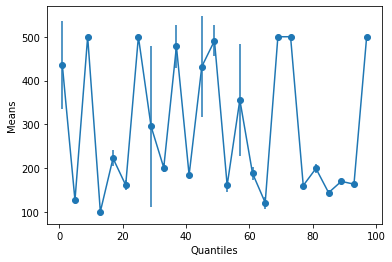

In [ ]:
fig, ax = plt.subplots()
plt.xlabel("Quantiles")
plt.ylabel("Means")

ax.errorbar(quantiles_domain, means, yerr=stds, fmt='-o');


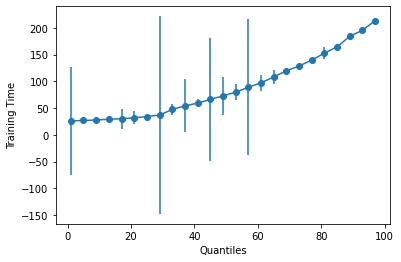

In [ ]:
fig, ax = plt.subplots()
plt.xlabel("Quantiles")
plt.ylabel("Training Time")

ax.errorbar(quantiles_domain, times, yerr=stds, fmt='-o');

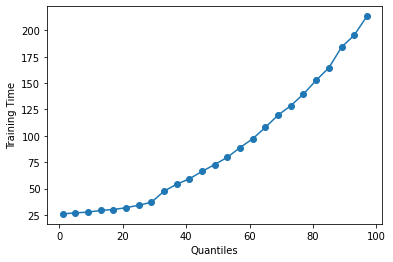

In [ ]:
fig, ax = plt.subplots()
plt.xlabel("Quantiles")
plt.ylabel("Training Time")
ax.errorbar(quantiles_domain, times, fmt='-o');

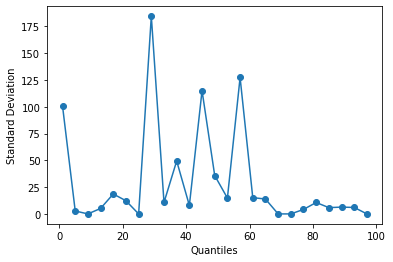

In [ ]:
fig, ax = plt.subplots()
plt.xlabel("Quantiles")
plt.ylabel("Standard Deviation")
ax.errorbar(quantiles_domain, stds, fmt='-o');